In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
import torch
import torchvision.transforms as transforms #データの前処理のため
from torch.utils.data import DataLoader
from collections import defaultdict

In [ ]:
#http://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html 参考に

data = MNIST(root="./MNIST", #torchvisionのimportだけの場合は，torchvision.datasets.MNIST(~とかく必要あり
             train=True, #訓練データに，Falseならテストデータ
             download=True, 
             transform=transforms.ToTensor() #データの正規化，テンソルに変換
             )

In [ ]:
data_loader = DataLoader(data, batch_size=64, shuffle=True) #分割してくれる

In [28]:
train_data = MNIST(root="./MNIST", #データを保存する場所
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor()
                   )

train_data_loader = DataLoader(train_data, 
                               batch_size=64, 
                               shuffle=True
                               )

test_data = MNIST(root="./MNIST", 
                  train=False, 
                  download=True, #テストデータなのでFalse
                  transform=transforms.ToTensor()
                  )

test_data_loader = DataLoader(test_data,
                              batch_size=64, 
                              shuffle=False
                              )

In [37]:
print(len(train_data_loader))

938


In [30]:
#複数行書いていたのが一行で済むあら不思議パイトーチ
#マジ便利や：https://pytorch.org/docs/stable/nn.functional.html
import torch.nn as nn

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #ここまでひな形
        self.relu = nn.ReLU() 
        self.pool = nn.MaxPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,32,3)

        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


net=Net()
print(net)

Net(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [32]:
# Optimizer を作成する。
optim = torch.optim.Adam(net.parameters())
#損失関数
criterion = nn.CrossEntropyLoss()

In [33]:
def train(model, data_loader, optim):
    """
    1エポック分の学習を行う。
        :param model: モデル
        :param device: デバイス
        :param data_loader: Data Loader
        :param optim: Optimizer
    """
    # モデルを学習モードに設定する。
    model.train()

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # データ及びラベルを計算を実行するデバイスに転送する。
        data, target = data.to(), target.to()

        # 順伝搬を行う。
        output = net(data)

        # 損失関数の値を計算する。
        loss = criterion(output, target)
        total_loss += float(loss)

        # 逆伝搬を行う。
        optim.zero_grad()
        loss.backward()

        # パラメータを更新する。
        optim.step()

        # 確率の最も高いクラスを予測ラベルとする。
        pred_target = output.argmax(dim=1)

        # 正答数を計算する。
        total_correct += int((pred_target == target).sum())

    # 損失関数の値の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [34]:
def test(model, data_loader):
    """
    テストデータに対する損失の平均及び精度を計算する。
        :param model: モデル
        :param device: デバイス
        :param data_loader: Data Loader
    """
    # モデルをテストモードに設定する。
    model.eval()

    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for data, target in data_loader:
            # データ及びラベルを計算を実行するデバイスに転送する。
            data, target = data.to(), target.to()

            # 順伝搬する。
            output = model(data)

            # 損失を計算する。
            loss = criterion(output, target)
            total_loss += float(loss)

            # 確率の最も高いクラスを予測ラベルとする。
            pred_target = output.argmax(dim=1)

            # 正答数を計算する。
            total_correct += int((pred_target == target).sum())

    # 損失の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [35]:

n_epochs = 50

history = defaultdict(list)
for epoch in range(n_epochs):
    # 1エポック分、学習する。
    train_loss, train_accuracy = train(net,  train_data_loader, optim)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)

    # 評価する。
    test_loss, test_accuracy = test(net,  test_data_loader)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)

    print(
        f"epoch {epoch + 1} "
        f"[train] loss: {train_loss:.6f}, accuracy: {train_accuracy:.0%} "
        f"[test] loss: {test_loss:.6f}, accuracy: {test_accuracy:.0%}"
    )

epoch 1 [train] loss: 0.003796, accuracy: 93% [test] loss: 0.001161, accuracy: 98%
epoch 2 [train] loss: 0.001042, accuracy: 98% [test] loss: 0.000768, accuracy: 98%
epoch 3 [train] loss: 0.000752, accuracy: 98% [test] loss: 0.000570, accuracy: 99%
epoch 4 [train] loss: 0.000589, accuracy: 99% [test] loss: 0.000624, accuracy: 99%
epoch 5 [train] loss: 0.000463, accuracy: 99% [test] loss: 0.000524, accuracy: 99%
epoch 6 [train] loss: 0.000381, accuracy: 99% [test] loss: 0.000518, accuracy: 99%
epoch 7 [train] loss: 0.000323, accuracy: 99% [test] loss: 0.000449, accuracy: 99%
epoch 8 [train] loss: 0.000258, accuracy: 99% [test] loss: 0.000459, accuracy: 99%
epoch 9 [train] loss: 0.000214, accuracy: 100% [test] loss: 0.000428, accuracy: 99%
epoch 10 [train] loss: 0.000197, accuracy: 100% [test] loss: 0.000452, accuracy: 99%
epoch 11 [train] loss: 0.000153, accuracy: 100% [test] loss: 0.000712, accuracy: 99%
epoch 12 [train] loss: 0.000142, accuracy: 100% [test] loss: 0.000568, accuracy: 9

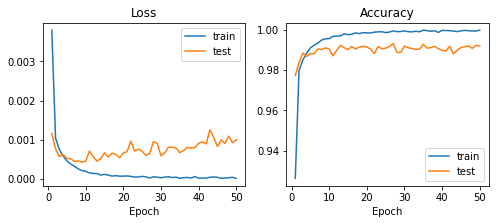

In [36]:
epochs = np.arange(1, n_epochs + 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

# 損失の推移
ax1.set_title("Loss")
ax1.plot(epochs, history["train_loss"], label="train")
ax1.plot(epochs, history["test_loss"], label="test")
ax1.set_xlabel("Epoch")
ax1.legend()

# 精度の推移
ax2.set_title("Accuracy")
ax2.plot(epochs, history["train_accuracy"], label="train")
ax2.plot(epochs, history["test_accuracy"], label="test")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()